In [ ]:
#!pip install azure-storage-blob
#!python -m nltk.downloader stopwords
#!python -m nltk.downloader punkt

In [2]:
import json
import re

import pandas as pd
import numpy as np

import string
import unicodedata
import html


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import spacy
from spacy.matcher import Matcher 
from spacy.tokens import Span
from tqdm import tqdm
nlp = spacy.load("en_core_web_sm")

import networkx as nx

from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__

In [3]:
#Blob Storage Connection
çompany_list = "dnbcompanieslist.csv"
connect_str="DefaultEndpointsProtocol=https;AccountName=seagullsstorage;AccountKey=1W2VlvlzxmzzQcRUULCSjFuhhTpGluxPBymj2Et4SCfTOpwPLZqquLW3qKl46+sMohn+SdvQkKsI+AStmcLbHQ==;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client("googlesearch")

In [7]:
# Delete
blob_list = container_client.list_blobs()

columns = ['source','search','link','content','content_clean']
df = pd.DataFrame(columns = columns)

lst = []
for blob in blob_list:
  #print(blob.name)
  if not('dnb' in blob.name) and not('nlp' in blob.name):
    downloaded_blob = container_client.download_blob(blob.name)
    #print(blob.name)
    blob_data = downloaded_blob.content_as_text()
    parsed = json.loads(blob_data)
    tmp = pd.json_normalize(parsed)
    df = df.append(tmp, ignore_index = True)


#'distilled resources inc/content_23.json',

#downloaded_blob = container_client.download_blob('distilled resources inc/content_23.json')
#blob_data = downloaded_blob.content_as_text()

#parsed = json.loads(blob_data)



In [14]:

df

,source,search,link,content,content_clean,sentence
0,google,"Arista Business Imaging Solutions, Inc.",https://www.linkedin.com/company/arista-busine...,,,[]
1,google,"Arista Business Imaging Solutions, Inc.",https://www.bloomberg.com/profile/company/0178...,Bloomberg Need help? Contact us We've d...,bloomberg need help ? contact us detected unus...,"[bloomberg need help , contact us detected un..."
2,google,"Arista Business Imaging Solutions, Inc.",https://clustrmaps.com/a/3t2dgs/,ClustrMaps Log In Sign Up 5153 Commercial...,clustrmaps log sign 5153 commercial cir concor...,[clustrmaps log sign 5153 commercial cir conco...
3,google,"Arista Business Imaging Solutions, Inc.",https://www.usaopps.com/government_contractors...,Join or Sign In Government Bids...,join sign government bids government contracto...,[join sign government bids government contract...
4,google,"Arista Business Imaging Solutions, Inc.",https://www.manta.com/c/mmnmn2k/arista-busines...,Please enable cookies. One more step Pl...,please enable cookies . one step please comple...,"[please enable cookies , one step please comp..."
...,...,...,...,...,...,...
321,google,"Wong Potatoes, Inc",https://www.generalproduce.com/sustainability/...,Skip to content Page Not Found Template...,skip content page found template found sustain...,[skip content page found template found sustai...
322,google,"Wong Potatoes, Inc",https://www.execupower.com/news,Our Company Services Substation Engineer...,company services substation engineering transm...,[company services substation engineering trans...
323,google,"Wong Potatoes, Inc",https://www.wongpotatoes.com/contact.html,Your browser does not ...,browser support script sales ken rutledge dan ...,[browser support script sales ken rutledge dan...
324,google,"Wong Potatoes, Inc",https://www.homesteadcapital.com/about/,"One Embarcadero Center, Suite 3860 Sa...",one embarcadero center suite 3860 san francisc...,[one embarcadero center suite 3860 san francis...


In [9]:
# This is a class to get clean text. 
class preprocessing:
    
    def __init__(self):
        pass

    #Cleaning and stripping HTML
    def remove_html_tags(self,text):
        clean = re.compile('<.*?>')
        cleantext = re.sub(clean, '', text)
        return cleantext

    #Removing Escaping characters &lt
    def escaping_html_char(self,doc):
        cleandoc = html.unescape(doc)
        return cleandoc
    
    #Removing newline & extra spaces
    def textcleaning(self,doc):
        # remove extra newlines
        a = doc.replace("\\n",".").strip()
        a = a.replace("\\r",".").strip()
        #a = re.sub(r'\d+','',a)# remove numbers
        cleandoc = re.sub("\s+"," ", a)
        return cleandoc
    
    def text_norm(self,doc):
        cleandoc = doc.lower()
        return cleandoc
    

    # Removing accented characters
    # A simple example — converting é to e.
    def decode_text(self,doc):
        cleandoc = unicodedata.normalize('NFKD', doc).encode('ascii','ignore').decode("utf8")
        return cleandoc
    
    def text_tokenize(self,doc):
        return word_tokenize(doc)
    
    def remove_stopwords(self,words):
        # set of stop words
        stop_words = set(stopwords.words('english')) 
        stext = [] 
        for w in words:
            if w not in stop_words:
                stext.append(w)
        return stext
    
    def remove_punctuation(self,doc):
        # Removing punctuations except '<.>/<?>/<!>'
        punctuations = '"#$%&\'()*+,-/:;<=>@\\^_`{|}~'
        table = str.maketrans(punctuations, ' '*len(punctuations))
        ##str.maketrans('', '', string.punctuation)
        cleandoc = doc.translate(table)
        #cleandoc=re.sub(r'[\W_]+', ' ', cleandoc)
        return cleandoc
    
    
    def questions_clean(self,text):
        text = re.sub(r'\n+', '\n', text).strip()
        return text
    
    
    def data_preprocessing(self,doc):
        doc = str(doc)

        step1 = self.remove_html_tags(doc)            # Cleaning and stripping HTML
        step2 = self.escaping_html_char(step1)        # Removing Escaping characters &lt
        step3 = self.textcleaning(step2)              # Removing newline & extra spaces
        step4 = self.text_norm(step3)                 # Case Normalization
        step5 = self.remove_punctuation(step4)        # Remove punctuation
        step6 = self.decode_text(step5)               # Text encoding - Removing accented characters
        step7 = self.text_tokenize(step6)             # Tokenization
        step8 = self.remove_stopwords(step7)          # Stop Words
        
        return " ".join(step8)

In [10]:
pre = preprocessing()
df['content_clean'] = df['content'].apply(pre.data_preprocessing)

In [12]:
# split sentences
def sentences(text):
    # split sentences and questions
    text = re.split('[.?]', text)
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

df = df.copy()
# sentences
df['sentence'] = df['content_clean'].apply(sentences)

In [13]:
df_new = df.groupby(['source', 'search', 'link']).sentence.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_3', axis = 1)
df_new.columns = ['source', 'search', 'link', 'sentence']

In [15]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [16]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  #matcher.add("matching_1", None, pattern) 
  matcher.add("names", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  #print(matches)
  if len(matches)>0:
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text) 
  else:
    return('')

In [17]:
entity_pairs = []

for i in tqdm(df_new["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 22164/22164 [03:05<00:00, 119.38it/s]


In [18]:
relations = []
             
for i in tqdm(df_new["sentence"]):
  relations.append(get_relation(i)) 

100%|██████████| 22164/22164 [02:57<00:00, 124.66it/s]


In [19]:
entity_pairs2 = entity_pairs
relations2 = relations
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|██████████| 22164/22164 [00:00<00:00, 1061143.69it/s]


In [20]:
source = []
target = []
edge = []
for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])

In [21]:
print("###################  Most popular source entites    ###################### \n",pd.Series(source).value_counts()[:10])
print("###################  Most popular target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Most popular relations         ###################### \n",pd.Series(edge).value_counts()[:20])

###################  Most popular source entites    ###################### 
                                   536
remotely pronouns gitlab           65
lorem ipsum dolor                  62
remotely  gitlab                   61
us                                 23
thank feedback                     18
third party advertisement hubs     18
bid idbazjbpwje                    15
temporary illinois assignment      15
vcs                                14
dtype: int64
###################  Most popular target entites    ###################### 
                                    368
amet consectetur adipisicing        61
us assistance                       19
real  advertisers                   18
perimeterx inc                      18
www                                 16
issues page                         16
distilled resources inc             15
temporary staffing agency texas     15
general client login login          15
dtype: int64
###################  Most popular relations       

In [ ]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df.iloc[:500], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

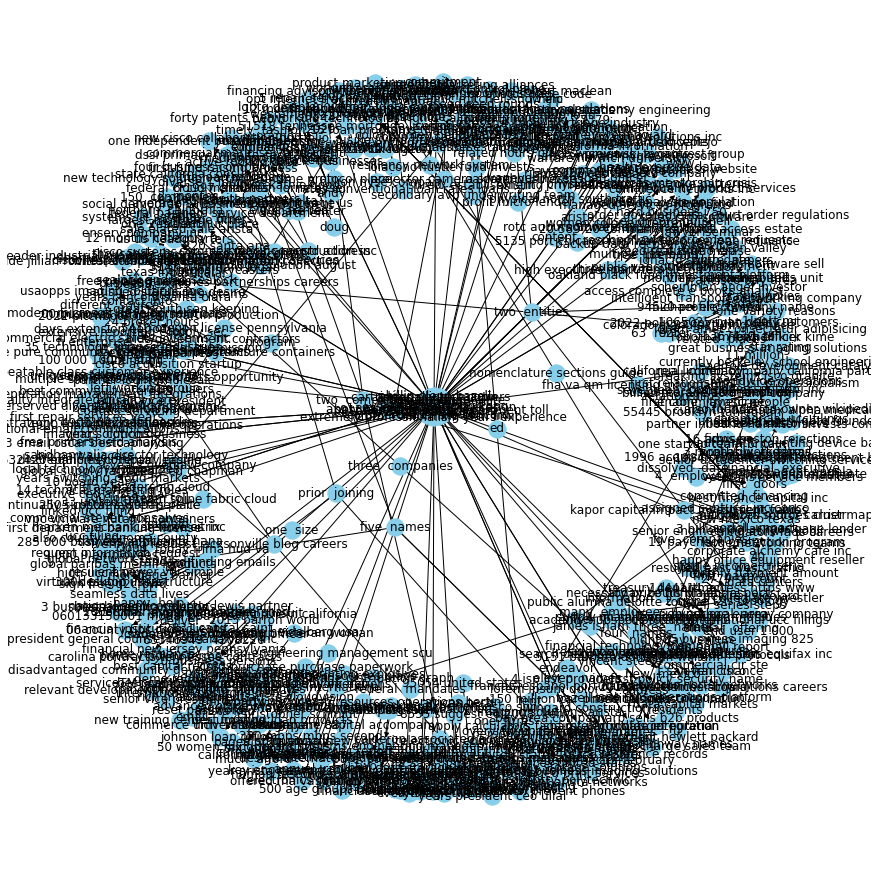

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

diverse = {'Minority Owned':['minority owned','black owned','african owned','latino','hispanic','indigenous','pacific american','indian american'],
           'Women Owned':['women owned'],
           'Disabled Owned':['disabled owned'],
           'LGBT':['lgbt'],
           'Veteran Owned':['veteran']
           }

search_list = df_new['search'].unique()
alst = []

for search in search_list:
  text_data = df_new[df_new.search==search]['sentence'].unique()
  # Create the tf-idf feature matrix
  tfidf_vectorizer = TfidfVectorizer()
  sparse_matrix = tfidf_vectorizer.fit_transform(text_data)
  doc_term_matrix = sparse_matrix.toarray()

  # Iterating over values
  for div, pat in diverse.items():
    for p in pat:
      tgt_transform = tfidf_vectorizer.transform([p]).toarray()
      tgt_cosine = cosine_similarity(doc_term_matrix,tgt_transform)
      arr = np.stack((text_data, tgt_cosine.flatten()), axis=1)
      for a in arr:
        alst.append([search,div,p,a[0],a[1]])

In [23]:
columns=['search','Diveristy','Category','text_found','similarity']
ndf = pd.DataFrame(alst,columns=columns)

ndf[ndf.search=='Vista Industrial Packaging, LLC'].sort_values('similarity').groupby(['search']).tail(10)

,search,Diveristy,Category,text_found,similarity
123669,"Vista Industrial Packaging, LLC",Minority Owned,minority owned,request update remove information company inf...,0.215003
126161,"Vista Industrial Packaging, LLC",Women Owned,women owned,toggle navigation sign contact us government c...,0.230214
126205,"Vista Industrial Packaging, LLC",Women Owned,women owned,request update remove information company inf...,0.233886
123362,"Vista Industrial Packaging, LLC",Minority Owned,minority owned,company female owned enterprise certified wom...,0.265033
123996,"Vista Industrial Packaging, LLC",Minority Owned,african owned,company female owned enterprise certified wom...,0.265033
123944,"Vista Industrial Packaging, LLC",Minority Owned,black owned,certified woman owned,0.355879
126480,"Vista Industrial Packaging, LLC",Disabled Owned,disabled owned,certified woman owned,0.355879
126163,"Vista Industrial Packaging, LLC",Women Owned,women owned,certified woman owned,0.370488
123627,"Vista Industrial Packaging, LLC",Minority Owned,minority owned,certified woman owned,0.561673
124261,"Vista Industrial Packaging, LLC",Minority Owned,african owned,certified woman owned,0.561673


NER

In [ ]:
#!pip install visualise_spacy_tree

In [ ]:
import spacy
from spacy.matcher import Matcher 

from spacy import displacy 
import visualise_spacy_tree
from IPython.display import Image, display

# load english language model
nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])

In [ ]:
# function to find sentences containing PMs of India
def find_names(text):
    
    names = []
    
    # spacy doc
    doc = nlp(text)
    
    # pattern
    pattern = [{'LOWER':'women'},
               {'LOWER':'owned'},
              {'POS':'NOUN'},
              {'POS':'VERB'}]
                
    # Matcher class object 
    matcher = Matcher(nlp.vocab) 
    matcher.add("names", None, pattern) 

    matches = matcher(doc)

    # finding patterns in the text
    for i in range(0,len(matches)):
        
        # match: id, start, end
        token = doc[matches[i][1]:matches[i][2]]
        # append token to list
        names.append(str(token))
            
    return names


In [ ]:
def prog_sent(text):
    
    patterns = [r'\b(?i)'+'owned'+r'\b']

    output = []
    flag = 0
    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    return flag 

# apply function
df_new['flag'] = df_new['sentence'].apply(prog_sent)

In [ ]:
# to extract initiatives using pattern matching
def all_schemes(text,check):
    
    schemes = []
    
    doc = nlp(text)
    
    # initiatives
    prog_list = ['owned']
    
    # pattern to match initiatives names 
    pattern = [
               #{'POS':'DET'},
               #{'POS':'PROPN','DEP':'compound'},
               #{'POS':'PROPN','DEP':'compound'},
               #{'POS':'PROPN','OP':'?'},
               #{'POS':'PROPN','OP':'?'},
               {'POS':'NOUN','OP':'?'},
               {'LOWER':{'IN':prog_list},'OP':'+'}
              ]
    
    if check == 0:
        # return blank list
        return ";".join(schemes)

    # Matcher class object 
    matcher = Matcher(nlp.vocab) 
    matcher.add("matching", None, pattern) 
    matches = matcher(doc)

    for i in range(0,len(matches)):
        
        # match: id, start, end
        start, end = matches[i][1], matches[i][2]
        
        if doc[start].pos_=='DET':
            start = start+1
        
        # matched string
        span = str(doc[start:end])
        
        if (len(schemes)!=0) and (schemes[-1] in span):
            schemes[-1] = span
        else:
            schemes.append(span)
        
    return ";".join(schemes)

# apply function
df_new['found'] = df_new.apply(lambda x:all_schemes(x.sentence,x.flag),axis=1)

In [ ]:
df_new[df_new['found']!=""]

,source,search,link,sentence,flag,found


In [ ]:

# apply function
txt = 'company female owned enterprise certified women'
doc=nlp(txt)
for token in doc:
    print(token.text,'->',token.pos_)

prog_sent(txt)

company -> NOUN
female -> PROPN
owned -> VERB
enterprise -> NOUN
certified -> VERB
women -> NOUN


1

In [71]:

company = 'Best Capital Funding'
text_data = df_new[df_new.search==company]['sentence'].unique()
# Create the tf-idf feature matrix
tfidf_vectorizer = TfidfVectorizer()
sparse_matrix = tfidf_vectorizer.fit_transform(text_data)
doc_term_matrix = sparse_matrix.toarray()

#df = df_new['sentence']
diverse = 'coo'


tgt_transform = tfidf_vectorizer.transform([diverse]).toarray()
tgt_cosine = cosine_similarity(doc_term_matrix,tgt_transform)
arr = np.stack((text_data, tgt_cosine.flatten()), axis=1)

In [72]:

a = np.array(arr)


res = a[np.flip(np.argsort(a[:,1]))][0]
print(res)

[' executive team mike yates ceo founder read mike bio ulrik singontiko co ceo founder read ulrik bio chad schoep coo president read chad bio 2020 best capital funding brought professional mortgage team grow 3 billion dollar mortgage lender '
 0.16420738417027958]


In [73]:
text= NER(res[0])
#for word in text.ents:
#    print(word.text,word.label_)

doc = nlp(res[0])

displacy.render(doc,style='ent',jupyter=True)